In [1]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text as sql_text

load_dotenv()

conn = create_engine(
    f"postgresql://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}@{os.getenv('PG_HOST')}/{os.getenv('PG_DBNAME')}"
).connect()

In [2]:
import pandas as pd
 
temp_readings = pd.read_sql_query(sql_text("SELECT * FROM public.temp_readings"), conn)
fire_alerts = pd.read_sql_query(sql_text("SELECT * FROM public.fire_alerts"), conn)
tweets = pd.read_sql_query(sql_text("SELECT * FROM public.tweets"), conn)

In [3]:
temp_readings

,day,xy,temperature,id
0,2196,"(6,0)",40,1975680
1,2196,"(6,1)",58,1975681
2,2196,"(6,2)",64,1975682
3,2196,"(6,3)",44,1975683
4,2196,"(6,4)",46,1975684
...,...,...,...,...
2294094,2196,"(5,25)",61,1975675
2294095,2196,"(5,26)",60,1975676
2294096,2196,"(5,27)",50,1975677
2294097,2196,"(5,28)",59,1975678


In [4]:
tweets

,day,xy,score,content,id
0,2548,"(4,21)",None,drew near the shore endeavoured to steer so th...,1709920
1,2548,"(4,22)",None,only we of the cabin party who perceived the d...,1709921
2,2548,"(4,22)",None,to night if you had not slain their deadly foe...,1709922
3,2548,"(4,22)",None,by rope suspended from the branches as sailors...,1709923
4,2548,"(4,22)",None,and donations to carry out its mission of incr...,1709924
...,...,...,...,...,...
1711158,2548,"(4,15)",None,ran few steps past me towards the hamlet cryin...,1709915
1711159,2548,"(4,21)",None,there we pulled easily by silver directions no...,1709916
1711160,2548,"(4,21)",None,brush for it in earnest and looked to my primi...,1709917
1711161,2548,"(4,21)",None,him know as well as could the meaning of what ...,1709918


In [5]:
fire_alerts

,event_day,notification_day,xy,id
0,29,32,"(1,25)",0
1,34,37,"(9,24)",1
2,38,41,"(20,24)",2
3,39,42,"(0,23)",3
4,39,42,"(28,7)",4
...,...,...,...,...
5600,2332,2335,"(27,7)",5600
5601,2333,2336,"(0,2)",5601
5602,2334,2337,"(13,9)",5602
5603,2340,2343,"(2,17)",5603


# Experiment #1: Predicting fire alerts using temperature readings
Every sector at every day has a temperature reading, while only some sectors have messages. To start, we'll try to predict fire alerts on the day of using temperature readings only from the past 7 days.

In [6]:
from tqdm import tqdm

def rolling_samples(series, window=7):
    output = []
    for i in range(window, len(series)):
        sample = series[i-window:i].tolist()
        output.append((sample, i))
    return output

samples = []
for name, group in tqdm(temp_readings.groupby('xy')):
    got_yes = False
    group = group.sort_values('day')
    events = fire_alerts[fire_alerts['xy'] == name]['event_day'].values
    temps = rolling_samples(group['temperature'].set_axis(group['day']))
    
    for temp, i in temps:
        samples.append((temp, 1 if i in events else 0))

100%|██████████| 900/900 [01:12<00:00, 12.41it/s]


In [7]:
import numpy as np

samples_x, samples_y = zip(*samples)
samples_x, samples_y = np.array(samples_x), np.array(samples_y)

len(samples_x)

2287799

In [8]:
samples_x

array([[54, 47, 59, ..., 56, 54, 55],
       [47, 59, 61, ..., 54, 55, 48],
       [59, 61, 56, ..., 55, 48, 41],
       ...,
       [35, 20, 42, ..., 40, 47, 43],
       [20, 42, 33, ..., 47, 43, 30],
       [42, 33, 40, ..., 43, 30, 47]])

In [9]:
samples_y

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(samples_x, samples_y, test_size=0.2)

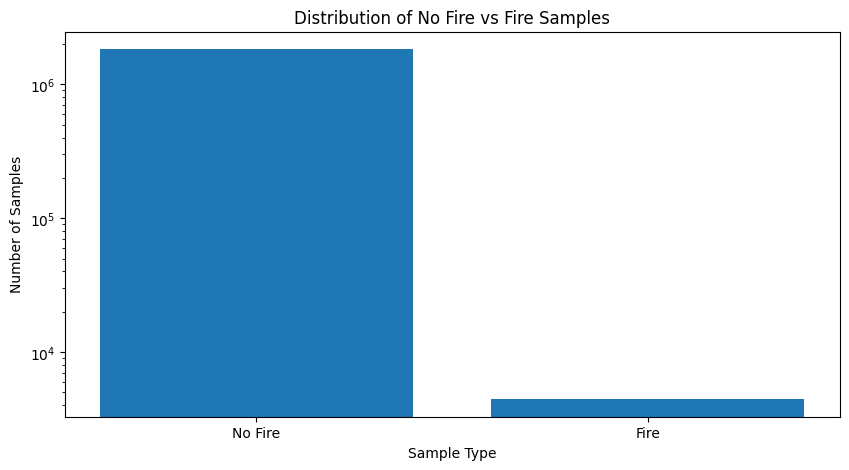

In [11]:
# plot distribution of samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [12]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# correct any imbalance before training
# smoteenn = SMOTEENN()
# train_x, train_y = smoteenn.fit_resample(train_x, train_y)

smote = SMOTE()
train_x, train_y = smote.fit_resample(train_x, train_y)

# rus = RandomUnderSampler()
# train_x, train_y = rus.fit_resample(train_x, train_y)

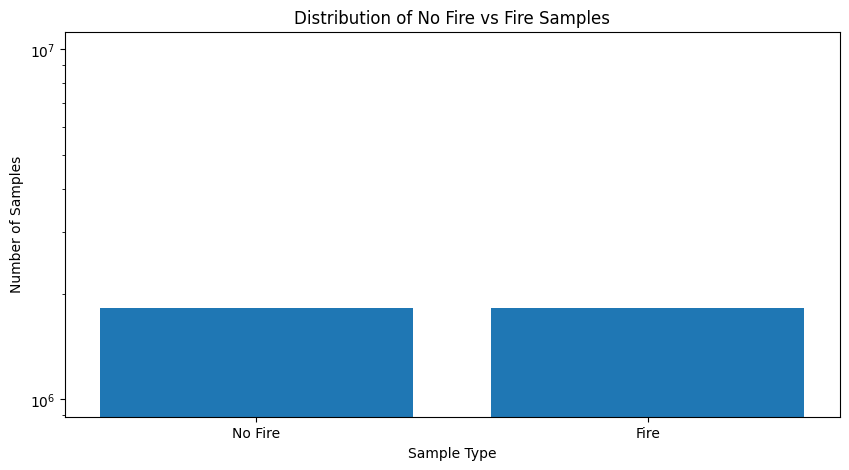

In [13]:
# let's plot after fixing it now
plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler

# function to preprocess our data
def preprocess_train(x_data, y_data):
    x_scaler = StandardScaler()
    x_data = x_scaler.fit_transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data, x_scaler

def preprocess_test(x_data, y_data, x_scaler):
    x_data = x_scaler.transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data

In [15]:
train_x, train_y, scaler = preprocess_train(train_x, train_y)
test_x, test_y = preprocess_test(test_x, test_y, scaler)

In [16]:
# save the scaler for future use
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [17]:
from keras import Sequential
from keras.layers import Dense

# implement a simple neural network
def build_model(length_x):
    model = Sequential([
        Dense(512, activation='swish', input_shape=(length_x,)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

2023-08-06 14:01:58.589968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 14:01:59.066018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )
]

dnn_model = build_model(len(samples_x[0]))

dnn_model.fit(
    train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=2048,
    validation_split=0.2,
    verbose=1,
)

2023-08-06 14:01:59.763174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 14:01:59.802099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 14:01:59.802159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 14:01:59.804321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 14:01:59.804429: I tensorflow/compile

Epoch 1/100


2023-08-06 14:02:02.078398: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd7f40122d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-06 14:02:02.078445: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-08-06 14:02:02.082681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-06 14:02:02.242615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-06 14:02:02.443481: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-08-06 14:02:02.508298: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1427/1427 [==============================] - 12s 7ms/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0267 - val_accuracy: 0.9933
Epoch 2/100
1427/1427 [==============================] - 11s 8ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.0296 - val_accuracy: 0.9919
Epoch 3/100
1427/1427 [==============================] - 11s 8ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.0297 - val_accuracy: 0.9918
Epoch 4/100
1427/1427 [==============================] - 11s 8ms/step - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.0290 - val_accuracy: 0.9924
Epoch 5/100
1427/1427 [==============================] - 10s 7ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0194 - val_accuracy: 0.9959
Epoch 6/100
1427/1427 [==============================] - 10s 7ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0254 - val_accuracy: 0.9935
Epoch 6: early stopping


In [19]:
dnn_model.evaluate(test_x, test_y, batch_size=512, return_dict=True)

894/894 [==============================] - 5s 5ms/step - loss: 0.0228 - accuracy: 0.9924


{'loss': 0.02276933565735817, 'accuracy': 0.9923507571220398}

In [20]:
# calculate the accuracy if we always predict [1, 0] to be the output
from sklearn.metrics import accuracy_score
import random

random_predictions = [random.choice([[0, 1], [1, 0]]) for _ in range(len(test_y))]

accuracy_score(test_y, np.array(random_predictions))

0.4989684412973162

In [21]:
# find the index of a [0, 1] example in the test y and predict it
idx = np.where(test_y == [0, 1])[0][0]
dnn_model.predict(test_x[idx:idx+1])

1/1 [==============================] - 0s 58ms/step


array([[3.0442807e-06, 9.9999690e-01]], dtype=float32)

The model is able to be somewhat accurate, but this relies purely on temperature data. Before we move on to NLP and text analysis, let's try implementing an LSTM for this problem

# Experiment #2: Predicting fire alerts using temperature readings with an LSTM
The LSTM will take in the temperature readings from the past 7 days and output a prediction for the 7th day.

In [22]:
lstm_train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
lstm_test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [23]:
from keras.layers import LSTM

def build_lstm_model(length_x):
    model = Sequential([
        LSTM(50, activation='swish', input_shape=(length_x, 1)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
lstm_model = build_lstm_model(len(samples_x[0]))

lstm_model.fit(
    lstm_train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=4096,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
714/714 [==============================] - 25s 33ms/step - loss: 0.1977 - accuracy: 0.9069 - val_loss: 0.0483 - val_accuracy: 0.9876
Epoch 2/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.0326 - val_accuracy: 0.9912
Epoch 3/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0399 - val_accuracy: 0.9889
Epoch 4/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.0242 - val_accuracy: 0.9932
Epoch 5/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.0164 - val_accuracy: 0.9966
Epoch 6/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0369 - val_accuracy: 0.9900
Epoch 7/100
714/714 [==============================] - 22s 31ms/step - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.0079 - val_ac

In [25]:
lstm_model.evaluate(lstm_test_x, test_y, batch_size=4096, return_dict=True)

112/112 [==============================] - 1s 10ms/step - loss: 0.0212 - accuracy: 0.9933


{'loss': 0.021204855293035507, 'accuracy': 0.9933080077171326}

In [26]:
idx = np.where(test_y == [0, 1])[0][0]
lstm_model.predict(test_x[idx:idx+1])

1/1 [==============================] - 0s 110ms/step


array([[4.0937002e-06, 9.9999595e-01]], dtype=float32)

In [27]:
# save our two temperature models
dnn_model.save('dnn_model.h5')
lstm_model.save('lstm_model.h5')

/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Experiment #3: Converting text to "temperature" data
We will try using sentiment analysis to convert text to "temperature" data (dubbed heat index).

In [ ]:
# combine data from tweets and temperature
# merge the two DataFrames on 'day' and 'xy' columns
merged_df = tweets.merge(temp_readings, on=['day', 'xy'])

# get the desired 'content' and 'temperature' columns 
tweet_samples = merged_df[['content', 'temperature']].values.tolist()

tweet_samples

In [ ]:
# now that we have our tweets and temperatures, let's try to train a sentiment analysis model to predict temperature from tweet content
# first, let's preprocess our data
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm

# download the stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# now, convert stopwords to set since lookup is faster in set
stopwords_set = set(stopwords.words('english'))

# then, modify the preprocess function
def preprocess_data(data):
    preprocessed_data = []
    for tweet in tqdm(data):
        tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet)
        tweet = tweet.lower().split()
        # you can now check in set, which is faster than list
        tweet = [lemmatizer.lemmatize(word) for word in tweet if word not in stopwords_set]
        tweet = ' '.join(tweet)
        preprocessed_data.append(tweet)
    return preprocessed_data

In [ ]:
# preprocess our data
preprocessed_tweets = preprocess_data([tweet[0] for tweet in tweet_samples])

In [ ]:
# now, let's try to train a sentiment analysis model
from sklearn.model_selection import train_test_split

# split our data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(preprocessed_tweets, [tweet[1] for tweet in tweet_samples], test_size=0.2,)

In [ ]:
# convert our data to a format that the model can understand
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# initialize the tokenizer
print('Fitting tokenizer...')
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x)

# convert our text to sequences
print('Converting text to sequences...')
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# pad our sequences
print('Padding sequences...')
train_padded = pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

# scale our temperatures
print('Scaling temperatures...')
temperature_scaler = StandardScaler()
train_y = temperature_scaler.fit_transform(np.array(train_y).reshape(-1, 1))
test_y = temperature_scaler.transform(np.array(test_y).reshape(-1, 1))

In [ ]:
# plot the distribution of temperatures
plt.hist([tweet[1] for tweet in tweet_samples], bins=100)
plt.title('Distribution of Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

In [ ]:
# save the temperature scaler
import pickle

with open('temperature_scaler.pkl', 'wb') as f:
    pickle.dump(temperature_scaler, f)

In [ ]:
# build our model
from keras.layers import Embedding, GlobalAveragePooling1D
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

def build_sentiment_model(lr=3e-5):
    model = Sequential([
        Embedding(10000, 16, input_length=100),
        GlobalAveragePooling1D(),
        Dense(16, activation='swish'),
        Dense(1, activation='linear')
    ])
    
    opt = Adam(learning_rate=lr)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', RootMeanSquaredError('rmse')])
    return model

In [ ]:
# train our model
sentiment_model = build_sentiment_model(lr=3e-7)

sentiment_model.fit(
    train_padded,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
sentiment_model.evaluate(test_padded, test_y, batch_size=64, return_dict=True)

In [ ]:
# try an example out
# pick a high heat index tweet
idx = np.where(test_y > 0)[0][0]
print(test_x[idx])

It is clear that the model is not performing well. This is because the temperature data is not linearly correlated with the sentiment of the tweet. We will try to use a different approach.

# Experiment #4: Using a pretrained sentiment analysis model
We will try to use a pretrained sentiment analysis model, BERT, to convert text to "temperature" data (dubbed heat index).

In [ ]:
from keras import Input, Model
from transformers import TFBertModel, BertTokenizerFast

def build_bert_model():
    # initialize the tokenizer
    bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    
    # initialize the model
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # build the model
    input_ids = Input(shape=(100,), dtype='int32')
    attention_mask = Input(shape=(100,), dtype='int32')
    embedding = bert_model(input_ids, attention_mask=attention_mask)[0]
    embedding = GlobalAveragePooling1D()(embedding)
    embedding = Dense(16, activation='swish')(embedding)
    output = Dense(1, activation='linear')(embedding)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    # freeze the bert model
    bert_model.trainable = False
    
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae', RootMeanSquaredError('rmse')])
    
    return model, bert_tokenizer

In [ ]:
# build the model
bert_model, bert_tokenizer = build_bert_model()

In [ ]:
# split our data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(preprocessed_tweets, [tweet[1] for tweet in tweet_samples], test_size=0.2, )

In [ ]:
# convert our data to a format that the BERT model can understand
# convert our text to sequences
print('Converting text to sequences...')
train_sequences = bert_tokenizer.batch_encode_plus(train_x, max_length=100, truncation=True, padding='max_length', return_tensors='tf')
test_sequences = bert_tokenizer.batch_encode_plus(test_x, max_length=100, truncation=True, padding='max_length', return_tensors='tf')

# scale our temperatures
print('Scaling temperatures...')
train_y = temperature_scaler.transform(np.array(train_y).reshape(-1, 1))
test_y = temperature_scaler.transform(np.array(test_y).reshape(-1, 1))

In [ ]:
# train our model
bert_model.fit(
    [train_sequences['input_ids'], train_sequences['attention_mask']],
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
bert_model.evaluate([test_sequences['input_ids'], test_sequences['attention_mask']], test_y, batch_size=64, return_dict=True)